# Análisis del mercado cripto utilizando Python y Kafka.

### Objetivos del Proyecto:

A grandes rasgos, el objetivo es replicar un bot de trading, sin la necesidad de que se realicen operaciones en el exchange, y será algo sencillo, ya que no nos interesa tanto el caso de uso, si no que aprendas a manejar kafka con datos en tiempo real y a desacoplar servicios mediante su uso.
   
La idea es que obtengas datos en tiempo real del mercado, mediante un streaming
manejado en kafka, por lo que el proyecto estará dividido en 3 segmentos:
   
* Funciones Objetivo.
* Funciones Extras.
* Incorporar Servicios:
    - Visualización de Datos.
    - Conexión a Base de Datos (este lo dejamos en la primer sección).
    - Servicios de ML.
    - Data Analytics.
    - Reportes.

### Instrucciones

* Recuerda que lo primero es hacer el fork del repo y posterior a eso crear una carpeta personal en tu repositorio, de esta forma podrás hacer un push a la rama de python, con todo tu código dentro de tu carpeta, nada fuera de ella.

###### NO DEBES MODIFICAR NADA EN EL REPO ORIGINAL!!!

* Crear las funciones enunciadas en los archivos *producer_functions.py*, *consumer_functions.py* y *project_functions.py* para obtener los puntos asociados a cada uno de ellas.

* Utilizar este jupyter notebook para probar tu código. Contiene un ejemplo sencillo de cómo tengo organizado mi script, pero puedes modificarlo como gustes, o incluso borrar todo y empezar de cero. Recuerda que necesitamos este jupyter notebook, ya que tendrá tu desarrollo paso a paso y el cómo pensaste los ejercicios.

* Durante el proceso, debes materializar al menos dos tablas en la db, referentes a:
    * Datos del Mercado como los recibes.
    * Datos generados a partir de tus transformaciones y tu estrategia (si creas alguna). No debes repetir los datos del mercado del punto anterior.

* Crear un archivo producer.py que contendrá todo el código necesario para el producer.

* Repetir el punto anterior para el consumer.

### Consejos y tips.

* Recuerda que el objetivo es separar los servicios, por lo que es esperado que trabajes con al menos 2 diferentes archivos, pero puedes trabajar incluso con más de dos archivos, si por ejemplo deseas más organización o si es complicado orgnizar las ideas y las conexiones entre ellas en un solo archivo. A veces ayuda separarlo todo y pensar la lógica de manera granular.

* También recuerda que solo los mensajes dentro de una partición están ordenados, NO se ordenan automáticamente si se envían a diferentes particiones, por lo que si haces esto, debes tener una forma de organizarlos y procesarlos posterior a recibirlos en los consumer.

* Enfocate en las funciones objetivo, después de ello, pasa a la segunda sección, de esa forma aseguras los puntos fáciles.

### TBD

Como ya lo mencioné, estamos a contra reloj creando el material para ustedes, por lo que los siguientes puntos están pendientes de entregarles.

* Es probable que añada algunas funciones más en las funciones objetivo, estén al pendiente durante el fin de semana.

* Las funciones extras: Agregué solo una de momento, pero hace falta agregar más.

* Incorporar servicios:
    - Alcanza el tiempo?
    - Cuáles?

* Los puntos asignados a cada función.

* Lo más probable es que KSQL no lo alcancemos a ver, pero aún hay esperanza.

In [16]:
import json
from sqlalchemy import create_engine

with open("db_credentials.json") as f:
    credentials = json.load(f)

user = credentials["user"]
password = credentials["password"]
host = credentials["host"]
db = credentials["db"]

try:
    connection_string = f'postgresql://{user}:{password}@{host}/{db}'
    engine = create_engine(connection_string)

    with engine.connect() as connection:
        print("Exito")
except Exception as e:
    print("Error: {e}")


Exito


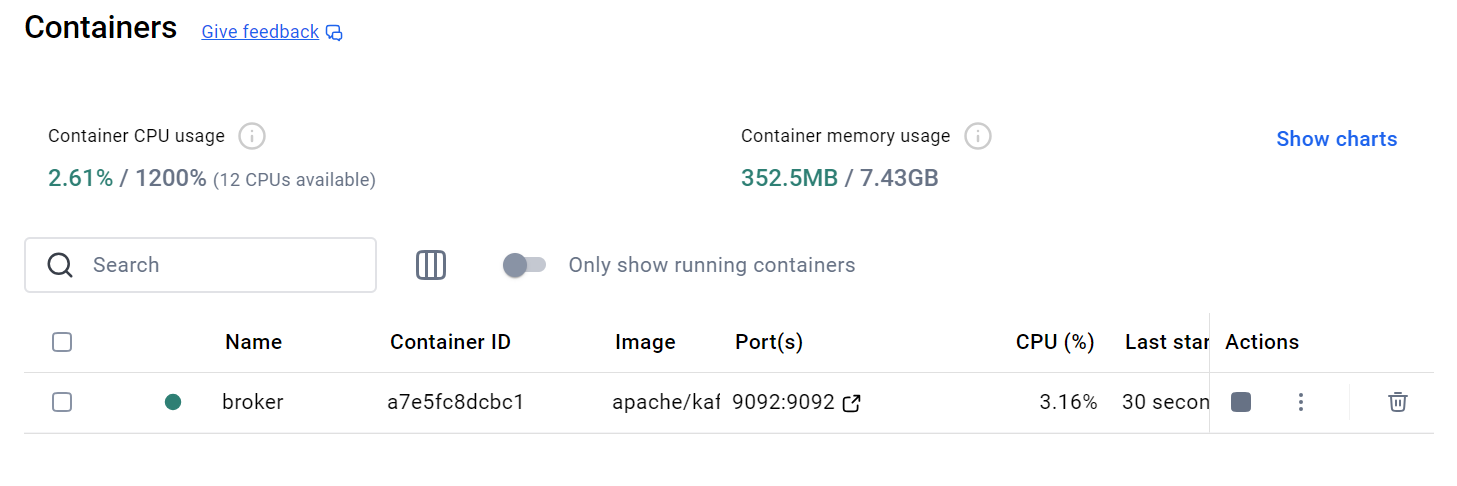

In [2]:
from kafka import KafkaConsumer
from json import loads

topic = "test_topic"
host = "localhost"
port = 9092

try:
    consumer = KafkaConsumer(
        topic,
        bootstrap_servers = f'{host}:{port}',
        value_deserializer = lambda v: loads(v.decode('utf-8')),
        auto_offset_reset = 'earliest',
        enable_auto_commit = True
    )
    print('Conexion exitosa')

        

except Exception as e:
    print('Error {e}')

Conexion exitosa


In [8]:
import pandas as pd

mock_message = type("MockMessage", (), {"value" : {
    "key" : "BTC",
    "price" : 500,
    "volume" : 1.23,
    "timestamp" : 1131638
}})

message_content = mock_message.value

df = pd.DataFrame([message_content])

print(df)

   key  price  volume  timestamp
0  BTC    500    1.23    1131638


In [9]:
import pandas as pd
from sqlalchemy import create_engine

# Ejemplo de configuración de la base de datos
user = "postgres"
password = 2468910
host = "localhost"
db = "crypto_db"
table_name = "market_data"

# Crear el motor de conexión a la base de datos
engine = create_engine(f"postgresql://{user}:{password}@{host}/{db}")

# DataFrame de prueba (simulando un mensaje procesado)
data = {
    "key": ["BTCUSDT"],
    "price": [50000.25],
    "volume": [1.2345],
    "timestamp": [pd.Timestamp.now()]
}
df = pd.DataFrame(data)

# Prueba de almacenamiento en la base de datos
try:
    # Guardar el DataFrame en la tabla especificada
    df.to_sql(table_name, con=engine, if_exists="append", index=False)
    print(f"Datos guardados exitosamente en la tabla '{table_name}'.")
except Exception as e:
    print(f"Error al guardar los datos: {e}")

Datos guardados exitosamente en la tabla 'market_data'.


In [10]:
from kafka import KafkaProducer
from json import dumps

def create_producer(bootstrap_servers="localhost:9092"):
    """
    Crea un productor Kafka para enviar mensajes a un tópico.

    Args:
        bootstrap_servers (str): Dirección del servidor Kafka.

    Returns:
        KafkaProducer: Productor configurado.
    """
    try:
        # Crear el productor Kafka
        producer = KafkaProducer(
            bootstrap_servers=bootstrap_servers,  # Dirección del broker Kafka
            value_serializer=lambda v: dumps(v).encode('utf-8')  # Serializar mensajes a JSON
        )
        print(f"Conexión exitosa al servidor Kafka: {bootstrap_servers}")
        return producer

    except Exception as e:
        print(f"Error al crear el productor Kafka: {e}")
        return None

# Prueba de la función
producer = create_producer()

if producer:
    print("El productor Kafka está listo para enviar mensajes.")
else:
    print("Hubo un problema al conectar con Kafka.")

Conexión exitosa al servidor Kafka: localhost:9092
El productor Kafka está listo para enviar mensajes.


In [11]:
import requests
import time

def get_market_data(symbol="BTCUSDT", interval="1m"):
    """
    Obtiene datos de mercado reales desde la API de Binance.

    Args:
        symbol (str): Símbolo del par de mercado (e.g., BTCUSDT).
        interval (str): Intervalo de tiempo para los datos (e.g., 1m, 5m, 1h).

    Returns:
        dict: Datos de mercado reales.
    """
    url = f"https://api.binance.com/api/v3/klines"
    params = {
        "symbol": symbol,
        "interval": interval,
        "limit": 1  # Solo queremos el último dato
    }

    try:
        # Realizar la solicitud a la API
        response = requests.get(url, params=params)
        response.raise_for_status()  # Lanza una excepción para códigos de estado no exitosos

        # Procesar los datos de la respuesta
        kline = response.json()[0]  # Tomar el último registro
        market_data = {
            "symbol": symbol,
            "open": float(kline[1]),
            "high": float(kline[2]),
            "low": float(kline[3]),
            "close": float(kline[4]),
            "volume": float(kline[5]),
            "timestamp": int(kline[6]) / 1000  # Convertir de milisegundos a segundos
        }

        return market_data

    except requests.exceptions.RequestException as e:
        print(f"Error al obtener datos de la API: {e}")
        return None

# Prueba de la función
market_data = get_market_data()
if market_data:
    print("Datos de mercado reales obtenidos:")
    print(market_data)
else:
    print("No se pudieron obtener datos de la API.")

Datos de mercado reales obtenidos:
{'symbol': 'BTCUSDT', 'open': 101079.87, 'high': 101335.6, 'low': 101007.46, 'close': 101016.0, 'volume': 150.42585, 'timestamp': 1733366819.999}


In [12]:
import pandas as pd

def clean_market_data(data):
    """
    Limpia y transforma los datos de mercado obtenidos desde la API.

    Args:
        data (dict): Datos de mercado obtenidos desde la API.

    Returns:
        pd.DataFrame: Datos limpios como un DataFrame de Pandas.
    """
    try:
        # Convertir los datos en un DataFrame
        df = pd.DataFrame([data])

        # Verificar que todas las columnas importantes están presentes
        required_columns = ["symbol", "open", "high", "low", "close", "volume", "timestamp"]
        for col in required_columns:
            if col not in df.columns:
                raise ValueError(f"Falta la columna requerida: {col}")

        # Convertir el timestamp a formato de fecha y hora
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

        # Validar que los valores numéricos no sean nulos o negativos
        numeric_columns = ["open", "high", "low", "close", "volume"]
        for col in numeric_columns:
            if (df[col] <= 0).any():
                raise ValueError(f"Los valores de '{col}' no pueden ser negativos o cero.")

        print(f"Datos limpios:\n{df}")
        return df

    except Exception as e:
        print(f"Error al limpiar los datos: {e}")
        return None

# Prueba de la función
raw_data = {
    "symbol": "BTCUSDT",
    "open": 27345.67,
    "high": 27378.9,
    "low": 27340.1,
    "close": 27350.55,
    "volume": 1234.5678,
    "timestamp": 1679445782.0
}

cleaned_data = clean_market_data(raw_data)

Datos limpios:
    symbol      open     high      low     close     volume  \
0  BTCUSDT  27345.67  27378.9  27340.1  27350.55  1234.5678   

            timestamp  
0 2023-03-22 00:43:02  


In [13]:
def processing_market_data(symbol="BTCUSDT", interval="1m"):
    """
    Procesa los datos de mercado:
    - Obtiene los datos desde la API.
    - Limpia los datos utilizando clean_market_data.
    - Devuelve los datos listos para su uso.

    Args:
        symbol (str): Símbolo del par de mercado (e.g., BTCUSDT).
        interval (str): Intervalo de tiempo para los datos (e.g., 1m, 5m, 1h).

    Returns:
        pd.DataFrame: Datos procesados y limpios como DataFrame.
    """
    try:
        # Obtener datos de la API
        raw_data = get_market_data(symbol=symbol, interval=interval)
        if not raw_data:
            raise ValueError("No se pudieron obtener datos de la API.")

        # Limpiar los datos
        processed_data = clean_market_data(raw_data)
        if processed_data is None:
            raise ValueError("Error al limpiar los datos.")

        print("Datos procesados correctamente.")
        return processed_data

    except Exception as e:
        print(f"Error al procesar los datos de mercado: {e}")
        return None

# Prueba de la función
processed_data = processing_market_data()
if processed_data is not None:
    print(processed_data)

Datos limpios:
    symbol       open      high        low      close    volume  \
0  BTCUSDT  100968.01  101088.0  100965.32  101087.99  44.36492   

                      timestamp  
0 2024-12-05 02:55:59.999000072  
Datos procesados correctamente.
    symbol       open      high        low      close    volume  \
0  BTCUSDT  100968.01  101088.0  100965.32  101087.99  44.36492   

                      timestamp  
0 2024-12-05 02:55:59.999000072  


In [15]:
def transformations(data, smooth_interval=3, smooth_exp=0.3):
    """
    Aplica transformaciones adicionales a los datos de mercado:
    - Calcula promedios móviles simples (SMA) y exponenciales (EMA).
    - Realiza operaciones adicionales según sea necesario.

    Args:
        data (pd.DataFrame): Datos procesados como DataFrame.
        smooth_interval (int): Ventana para el cálculo del promedio móvil simple.
        smooth_exp (float): Factor de suavizado para el promedio móvil exponencial.

    Returns:
        pd.DataFrame: Datos transformados con nuevas columnas.
    """
    try:
        # Asegurarse de que las columnas necesarias están presentes
        if "close" not in data.columns:
            raise ValueError("La columna 'close' es necesaria para las transformaciones.")

        # Calcular promedio móvil simple (SMA)
        data["SMA"] = data["close"].rolling(window=smooth_interval).mean()

        # Calcular promedio móvil exponencial (EMA)
        data["EMA"] = data["close"].ewm(span=smooth_interval, adjust=False).mean()

        print("Transformaciones aplicadas correctamente.")
        return data

    except Exception as e:
        print(f"Error al aplicar transformaciones: {e}")
        return None

# Prueba de la función
import pandas as pd

# Datos simulados para prueba
data = pd.DataFrame({
    "symbol": ["BTCUSDT"] * 5,
    "close": [27345.67, 27350.55, 27360.1, 27340.0, 27370.0],
    "timestamp": pd.date_range(start="2023-03-21", periods=5, freq="min")
})

# Aplicar transformaciones
transformed_data = transformations(data)
if transformed_data is not None:
    print(transformed_data)

Transformaciones aplicadas correctamente.
    symbol     close           timestamp           SMA          EMA
0  BTCUSDT  27345.67 2023-03-21 00:00:00           NaN  27345.67000
1  BTCUSDT  27350.55 2023-03-21 00:01:00           NaN  27348.11000
2  BTCUSDT  27360.10 2023-03-21 00:02:00  27352.106667  27354.10500
3  BTCUSDT  27340.00 2023-03-21 00:03:00  27350.216667  27347.05250
4  BTCUSDT  27370.00 2023-03-21 00:04:00  27356.700000  27358.52625


In [1]:
import os
from binance.client import Client
import pandas as pd
import datetime, time

def GetHistoricalData(self, howLong):
    self.howLong = howLong
    # Calculate the timestamps for the binance api function
    self.untilThisDate = datetime.datetime.now()
    self.sinceThisDate = self.untilThisDate - datetime.timedelta(days = self.howLong)
    # Execute the query from binance - timestamps must be converted to strings !
    self.candle = self.client.get_historical_klines("BNBBTC", Client.KLINE_INTERVAL_1MINUTE, str(self.sinceThisDate), str(self.untilThisDate))

    # Create a dataframe to label all the columns returned by binance so we work with them later.
    self.df = pd.DataFrame(self.candle, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    # as timestamp is returned in ms, let us convert this back to proper timestamps.
    self.df.dateTime = pd.to_datetime(self.df.dateTime, unit='ms').dt.strftime(Constants.DateTimeFormat)
    self.df.set_index('dateTime', inplace=True)

    # Get rid of columns we do not need
    self.df = self.df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)

    print(self.df)

In [ ]:
from IPython.display import clear_output # You can use this to clean your output in every loop.
from json import loads

from datetime import datetime as dt
import consumer_functions as cf
import project_functions1 as proj_f

### DB Connection Variables.
###### Recuerda NO subir tus credenciales a github: siempre puedes crear un JSON, mantener tus credenciales ahí e ingresarlo en tu .gitignore.

json_creds = loads('/path/to/json/credentials')
user = json_creds['']
password = json_creds['']
host = json_creds['']
db = json_creds['']
table_name = 'BTCFDUSD'

### Topic name.
dw_mk_topic='dw.market.data'

# Connection to our database.
engine = cf.db_engine(user,password,host,db)

# Consumer creation and TopicPartition usage.
dw_mk_consumer = cf.consumer(dw_mk_topic)

# Loop over the consumer for the latest message they received.
for dw_mk_msg in dw_mk_consumer:
    
    # Cleaning the output on the cells of .ipynb files.
    # clear_output(wait=True) 
    
    if dw_mk_msg.value:
        # Handling the message value into readable format and creating a dataframe from it.
        cf.handling_message(dw_mk_msg)
        cf.db_materialization(table_name,engine)

In [ ]:
from datetime import datetime as dt
import producer_functions1 as prod_f
import project_functions1 as proj_f

current_time = dt.now()

### get_market_data() & processing_market_data().
type_market_data = ''
symbol = ''
interval = ''
rows = ''

prod_f.create_producer()

i = 0
while True:
    
    ##################################################################################################################################
    # Descarga y limpieza de datos de X días atrás a hoy.
    ##################################################################################################################################       
    recent_data, market_data_msg, received_time = prod_f.processing_market_data(type_market_data,symbol,interval,rows)
    
    if current_time != recent_data.iloc[-1,0]:
        
        recent_data = prod_f.transformations(recent_data)
        recent_data = proj_f.strategy(recent_data)